## Cuisine prediction using recipe-ingredient data

### 1. Proposal

In this project, we aim to design a prediction system that uses recipe-ingredient data to predict the cuisine of a given recipe. We aim to utilize and consequently compare techniques from following domains: Simple (baseline) heuristics, Machine Learning, and Network-based heuristics

**Techniques we would try:**

1. Simple heuristics (these will serve as our baseline models)
    1. Baseline #1: ​For each ingredient belonging to the given test ingredient list, find the cuisine in which this ingredient is used the most. Among all such cuisines, pick the most frequently occurring cuisine
    2. Baseline #2: ​Rank the set of training recipes based on number of ingredients common with test ingredient list. Assign weights to recipes based on their rank and add to scores of their corresponding cuisines. Finally, choose the cuisine with the highest score
2. Machine Learning Domain
    1. Models such as ​Neural Networks, SVMs​ to be evaluated
    2. Models such as ​Neural Networks, SVMs​ to be evaluated with ​Node2Vec
    embeddings​ as features (where each node corresponds to an ingredient; and the
    graph is the unipartite projection recipe-ingredient bipartite network)
3. Network-based heuristics
    1. Do ​clustering​ on ingredient-ingredient network (projection of original bipartite
    recipe-ingredient network) using hierarchical clustering algorithms. We try to choose clusters at a level such that #clusters = #cuisines in our train set
    We ​analyze​ if these generated clusters have one-to-one correlation with different cuisines. If yes, we can use these clusters to create a prediction heuristic in which the cuisine having most number of test ingredients (i.e. the cluster having most number of nodes out of a given set of nodes) is picked
    2. Do ​clustering​ of ingredients using ​K-means​ on Node2Vec embeddings of ingredient-ingredient network(we set K = # cuisines). We ​analyze​ if these generated clusters have one-to-one correlation with different cuisines. If yes, we can use these clusters to create a prediction heuristic in which the cuisine having most number of test ingredients (i.e. the cluster having most number of nodes out of a given set of nodes) is picked
    3. Consider the recipe-ingredient bipartite network. For every ingredient in test list, we do: add ​w​ to scores of cuisines of recipes that are at ​distance​ of 1 from that ingredient, add ​w/2​ to scores of cuisines of recipes that are at ​distance​ of 3 from that ingredient and so on. This is done for each ingredient in the test list and the cuisine with highest score is chosen.

### 2. Getting to know the data

- Print statistics about the train data

Total number of recipes: 39774
Number of cuisines: 20
Cuisine count map: 

          irish: 667
        mexican: 6438
        chinese: 2673
       filipino: 755
     vietnamese: 825
       moroccan: 821
      brazilian: 467
       japanese: 1423
        british: 804
          greek: 1175
         indian: 3003
       jamaican: 526
         french: 2646
        spanish: 989
        russian: 489
   cajun_creole: 1546
           thai: 1539
    southern_us: 4320
         korean: 830
        italian: 7838


Number of ingredients: 6714


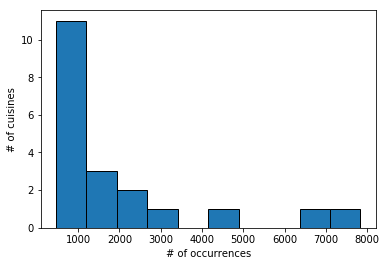

Summary statistics of above graph
            series
count    20.000000
mean   1988.700000
std    2041.558772
min     467.000000
25%     791.750000
50%    1082.000000
75%    2652.750000
max    7838.000000


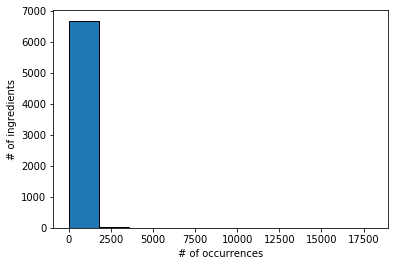

Summary statistics of above graph
             series
count   6714.000000
mean      63.788353
std      388.355948
min        1.000000
25%        1.000000
50%        4.000000
75%       20.000000
max    18049.000000
Average number of ingredients per recipe: 10.7677125761
Std. dev. number of ingredients per recipe: 4.42892189306


In [141]:
import json
import numpy as np

cuisines = set()
ingredients = set()

cuisine_count_map = {}
ingredient_count_map = {}

num_ingredients_per_recipe = []

def show_hist_of_dict(count_map, y_label, x_label):
    import matplotlib.pyplot as plt
    % matplotlib inline
    fig, ax = plt.subplots(1, 1)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.hist(count_map.values(), ec='black')
    plt.show()
    
    # print summary statistics
    print('Summary statistics of above graph')
    import pandas as pd
    series = {'series': pd.Series(count_map.values())}
    data_frame = pd.DataFrame(series)
    print(data_frame.describe())


with open('whats-cooking/train.json', 'r') as file:
    data = json.load(file)
    
    # print number of recipes
    print('Total number of recipes: {}'.format(len(data)))
    
    for recipe in data:
    
        # stats on number of cuisines
        cuisines.add(recipe['cuisine'])
        if recipe['cuisine'] not in cuisine_count_map:
            cuisine_count_map[recipe['cuisine']] = 0
        cuisine_count_map[recipe['cuisine']] += 1
        
        # stats on number of ingredients
        num_ingredients_per_recipe.append(len(recipe['ingredients']))
        for ingredient in recipe['ingredients']:
            ingredients.add(ingredient)
            
            if ingredient not in ingredient_count_map:
                ingredient_count_map[ingredient] = 0
            ingredient_count_map[ingredient] += 1
    
    print('Number of cuisines: {}'.format(len(cuisines)))
    print('Cuisine count map: \n')
    for cuisine in cuisine_count_map:
        print('{:>15}: {}'.format(cuisine, cuisine_count_map[cuisine]))
    print('\n')
    print('Number of ingredients: {}'.format(len(ingredients)))
    
    # show histogram of ingredients and cuisines
    show_hist_of_dict(cuisine_count_map, '# of cuisines', '# of occurrences')
    show_hist_of_dict(ingredient_count_map, '# of ingredients', '# of occurrences')
    
    # print average number of ingredients per recipe
    print('Average number of ingredients per recipe: {}'.format(np.mean(num_ingredients_per_recipe)))
    print('Std. dev. number of ingredients per recipe: {}'.format(np.std(num_ingredients_per_recipe)))

From the above, we can reason that most ingredients are used sparingly while only a few ingredients are used a lot

- Print statistics about the test data

Total number of recipes: 9944
Number of ingredients: 4484


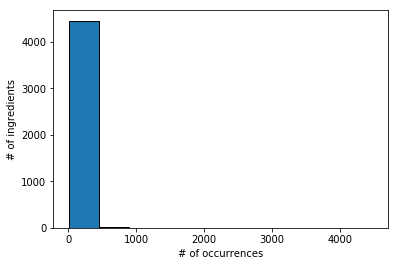

Summary statistics of above graph
            series
count  4484.000000
mean     23.950714
std     117.785328
min       1.000000
25%       1.000000
50%       3.000000
75%      11.000000
max    4485.000000
Statistics on number of ingredients per recipe:
Average number of ingredients per recipe: 10.7999798874
Std. dev. number of ingredients per recipe: 4.46692907371
            series
count  9944.000000
mean     10.799980
std       4.467154
min       1.000000
25%       8.000000
50%      10.000000
75%      13.000000
max      50.000000


In [67]:
import json
import numpy as np

ingredients = set()
ingredient_count_map = {}
num_ingredients_per_recipe = []

def show_hist_of_dict(count_map, y_label, x_label):
    import matplotlib.pyplot as plt
    % matplotlib inline
    fig, ax = plt.subplots(1, 1)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.hist(count_map.values(), ec='black')
    plt.show()
    
    # print summary statistics
    print('Summary statistics of above graph')
    import pandas as pd
    series = {'series': pd.Series(count_map.values())}
    data_frame = pd.DataFrame(series)
    print(data_frame.describe())


with open('whats-cooking/test.json', 'r') as file:
    data = json.load(file)
    
    # print number of recipes
    print('Total number of recipes: {}'.format(len(data)))
    
    for recipe in data:
            
        # stats on number of ingredients
        num_ingredients_per_recipe.append(len(recipe['ingredients']))
        for ingredient in recipe['ingredients']:
            ingredients.add(ingredient)
            
            if ingredient not in ingredient_count_map:
                ingredient_count_map[ingredient] = 0
            ingredient_count_map[ingredient] += 1
    
    print('Number of ingredients: {}'.format(len(ingredients)))
    
    # show histogram of ingredients and cuisines
    show_hist_of_dict(ingredient_count_map, '# of ingredients', '# of occurrences')
    
    # print average number of ingredients per recipe
    print('Statistics on number of ingredients per recipe:')
    print('Average number of ingredients per recipe: {}'.format(np.mean(num_ingredients_per_recipe)))
    print('Std. dev. number of ingredients per recipe: {}'.format(np.std(num_ingredients_per_recipe)))
    import pandas as pd
    series = {'series': pd.Series(num_ingredients_per_recipe)}
    data_frame = pd.DataFrame(series)
    print(data_frame.describe())

From the above, we can reason that even in test data most ingredients are used sparingly while only a few occur a lot of times

### 3. Create a separate train-test split from original train data

Although we will evaluate results of each model on Kaggle's hidden test set, we here would also create a separate train-test split using the training set from Kaggle so that we can do our own analysis properly. This is necessary since Kaggle's test set is hidden and we don't have access to it, so we can only get the accuracy result on that by submitting on Kaggle and no other metric can be evaluated as such; but if we create our own train-test split we can do a more in-depth analysis

In [2]:
import random
import json

# ratio of original data to be held out
test_percent = 0.3

with open('whats-cooking/train.json', 'r') as file:
    data = json.load(file)
    random.shuffle(data)
    
    test_len = int(test_percent * len(data))
    test_split = data[:test_len]
    train_split = data[test_len:]
    
    with open('my_train_split.json', 'w') as outfile:
        json.dump(train_split, outfile, indent=4)
    with open('my_test_split.json', 'w') as outfile:
        json.dump(test_split, outfile, indent=4)

In [4]:
# cross-check
files = ['my_train_split.json', 'my_test_split.json', 'whats-cooking/train.json']

for filename in files:
    with open(filename, 'r') as infile:
        data = json.load(infile)
        print('{} has {} entries'.format(filename, len(data)))

my_train_split.json has 27842 entries
my_test_split.json has 11932 entries
whats-cooking/train.json has 39774 entries


### 4. Baseline

Define some helper functions

In [136]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# returns most common element in a list
def most_common(lst):
    return max(set(lst), key=lst.count)
# function to plot confusion matrix
def show_confusion_matrix(y_predicted, y_true, label_to_string_map=None):
    # labels, counts = np.unique(y_true, return_counts=True)
    labels = np.unique(list(cuisines))
    map_label_to_index = { label : i for i, label in enumerate(labels) }
    
    # compute confusion matrix
    confusion_matrix = np.zeros((labels.shape[0], labels.shape[0]), dtype=int)
    for prediction_label, true_label in zip(y_predicted, y_true):
        confusion_matrix[map_label_to_index[true_label], map_label_to_index[prediction_label]] += 1
    
    # plot confusion matrix
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    fig.suptitle('Confusion matrix', fontsize=20)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    labels_yaxes = [ '{}'.format(label) for label in labels ]
    labels_xaxes = [ '{}'.format(label) for label in labels ]
    ax.set_xticklabels([''] + labels_xaxes)
    ax.set_yticklabels([''] + labels_yaxes)
    im = ax.matshow(confusion_matrix, cmap='coolwarm')
    # attribution for following two lines: https://stackoverflow.com/questions/20998083/show-the-values-in-the-grid-using-matplotlib
    for (i, j), z in np.ndenumerate(confusion_matrix):
        ax.text(j, i, '{}'.format(z), ha='center', va='center')
    fig.colorbar(im)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.tick_params(axis='x', labelrotation=60)
    plt.show()

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

# function that prints analysis metrics between ground truth and predictions
def common_validate(ground_truth_labels, predictions):
    
    # show confusion matrix
    show_confusion_matrix(predictions, ground_truth_labels)
    
    # show accuracy
    accuracy = accuracy_score(ground_truth_labels, predictions)
    print('1. Accuracy = {} (i.e. {} %)\n'.format(accuracy, accuracy * 100))
    
    # show f1-score
    labels = np.unique(ground_truth_labels)
    f1_scores = f1_score(ground_truth_labels, predictions, labels=labels,average=None)
    print('2. f1_scores for each class:\n')
    for i, label in enumerate(labels):
        print('{:>20}:\t{:.4f}'.format(label, f1_scores[i]))
    print('\n')
    print('3. avg f1_score (without considering class imbalance): {}\n'.format(f1_score(ground_truth_labels, predictions, average='macro')))
    print('4. avg f1_score (weighted by considering class imbalance): {}\n'.format(f1_score(ground_truth_labels, predictions, average='weighted')))

#### Baseline #1
For each ingredient belonging to the given test ingredient list, find the cuisine in which this ingredient is used the most. Among all such cuisines, pick the most frequently occurring cuisine

In [137]:
import json
import operator

class Baseline_1_Model:
    
    def __init__(self):
        is_trained = False
    
    # trains the model with entries from train_file
    def train(self, train_file):
        self.ingredient_cuisine_count_map = {}
        self.ingredients = set()
    
        # calculate for each ingredient, how many times it appears in each cuisine
        with open(train_file, 'r') as file:
            data = json.load(file)    
            for recipe in data:
                for ingredient in recipe['ingredients']:  
                    self.ingredients.add(ingredient)
                    if ingredient not in self.ingredient_cuisine_count_map:
                        self.ingredient_cuisine_count_map[ingredient] = {}
                    if recipe['cuisine'] not in self.ingredient_cuisine_count_map[ingredient]:
                        self.ingredient_cuisine_count_map[ingredient][recipe['cuisine']] = 0
                    self.ingredient_cuisine_count_map[ingredient][recipe['cuisine']] += 1
        
        self.is_trained = True
    
    # returns prediction results for entries of infile
    # it returns two arrays ids, predictions
    # predictions[i] is the predicted cuisine of entry with id ids[i]
    def predict(self, infile):
        assert self.is_trained, 'model not trained yet!'
        
        # a function that returns cuisine in which a given ingredient is used most
        def most_used_cuisine_of_ingredient(ingredient):
            return max(self.ingredient_cuisine_count_map[ingredient].iteritems(), key=operator.itemgetter(1))[0]

        predictions = []
        ids = []
        with open(infile, 'r') as file:
            data = json.load(file)
            for recipe in data:
                candidate_cuisines = []
                for ingredient in recipe['ingredients']:
                    if ingredient in self.ingredients:
                        candidate_cuisines.append(most_used_cuisine_of_ingredient(ingredient))
                predicted_cuisine = most_common(candidate_cuisines)
                predictions.append(predicted_cuisine)
                ids.append(recipe['id'])
                
        return ids, predictions
    
    # validates already trained model against entries from validation_file
    def validate(self, validation_file):
        assert self.is_trained, 'model not trained yet!'
        ids, predictions = self.predict(validation_file)
        id_to_ground_truth_cuisine = {}
        with open(validation_file, 'r') as infile:
            data = json.load(infile)
            for recipe in data:
                id_to_ground_truth_cuisine[recipe['id']] = recipe['cuisine']
        ground_truth_labels = [id_to_ground_truth_cuisine[id] for id in ids]
        common_validate(ground_truth_labels, predictions)
    
    # writes out prediction of already trained model on entries of test_file to out_file
    # out_file can then be submitted on Kaggle
    def write_prediction(self, test_file, outfile):
        assert self.is_trained, 'model not trained yet!'
        with open(outfile, 'w') as out_file:
            out_file.write('id,cuisine\n')
            ids, predictions = self.predict(test_file)
            assert len(ids) == len(predictions), 'these should be equal'
            N = len(ids)
            for i in range(N):
                out_file.write('{},{}\n'.format(ids[i], predictions[i]))

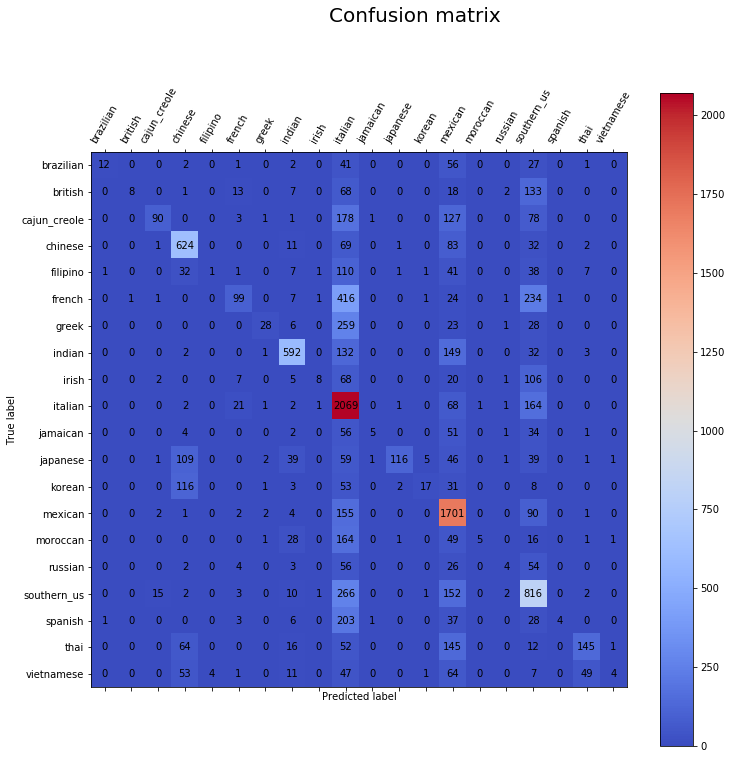

1. Accuracy = 0.532014750251 (i.e. 53.2014750251 %)

2. f1_scores for each class:

           brazilian:	0.1538
             british:	0.0618
        cajun_creole:	0.3046
             chinese:	0.6794
            filipino:	0.0081
              french:	0.2097
               greek:	0.1466
              indian:	0.7077
               irish:	0.0699
             italian:	0.6039
            jamaican:	0.0617
            japanese:	0.4280
              korean:	0.1323
             mexican:	0.6987
            moroccan:	0.0368
             russian:	0.0491
         southern_us:	0.5028
             spanish:	0.0278
                thai:	0.4475
          vietnamese:	0.0323


3. avg f1_score (without considering class imbalance): 0.26812406245

4. avg f1_score (weighted by considering class imbalance): 0.459364215925



In [138]:
# analyze on our own train-test split
baseline_1_model = Baseline_1_Model()
baseline_1_model.train('my_train_split.json')
baseline_1_model.validate('my_test_split.json')

** Inferences from above results **

1. From the confusion matrix, we can see that this model predicts some cuisines a lot of times (such as italian, mexican). This is not surprising given the logic with which the model is making the predictions; the cuisines that the model is predicting often are also the ones that occur in data a lot many times and the ones that the model is predicting sparingly are the ones that occur the very less number of times in the data
2. Accuracy that we achieve here is about 53%
3. From the f1-scores of each class, it is immediately apparent that those cuisines that we predict frequently (such as italian, mexican, southern_us, etc.) have higher f1-scores than those cuisines that we predict sparingly (such as brazilian, irish, moroccan, etc.). This is not surprising given the logic with which the model is making the predictions
4. Due to this imbalance of f1-scores based on the frequency of cuisine's occurrence, the unweighted average f1-score turns out to be significanly smaller (around 0.26) than its weighted counterpart (around 0.45)

Now we train the baseline model on entire training data that is available and then make predictions on Kaggle's test data (whose ground truth we don't know) and submit on Kaggle to check the accuracy we get

In [62]:
# train on entire data set and check accuracy on Kaggle
baseline_1_model_whole = Baseline_1_Model()
baseline_1_model_whole.train('whats-cooking/train.json')
baseline_1_model_whole.write_prediction('whats-cooking/test.json', 'Submissions/baseline_1_submission.csv')

I submitted the results of above baseline on Kaggle and got an accuracy of 0.53047 (i.e. **53.047 %**). The accuracy is similar to the one we got on our own train-test split.

#### Baseline #2
Rank the set of training recipes based on number of ingredients common with test ingredient list. Assign weights to recipes based on their rank and add to scores of their corresponding cuisines. Finally, choose the cuisine with the highest score

In [146]:
import json
import operator

class Baseline_2_Model:
    
    def __init__(self):
        is_trained = False
    
    # trains the model with entries from train_file
    def train(self, train_file):
        self.recipes = []
        with open(train_file, 'r') as file:
            data = json.load(file)    
            for recipe in data:
                self.recipes.append(recipe)
        self.is_trained = True
    
    # returns prediction results for entries of infile
    # it returns two arrays ids, predictions
    # predictions[i] is the predicted cuisine of entry with id ids[i]
    def predict(self, infile):
        assert self.is_trained, 'model not trained yet!'
        
        predictions = []
        ids = []
        with open(infile, 'r') as file:
            data = json.load(file)
            M = len(data)
            for recipe_num, recipe in enumerate(data):
                # print progress
                if recipe_num % int((M * 0.10)) == 0:
                    print('{}% of predictions done'.format(recipe_num * 100.0 / M))
                
                common_ingredient_counts = []
                for train_recipe in self.recipes:
                    common_ingredients = set(recipe['ingredients']) - (set(recipe['ingredients']) - set(train_recipe['ingredients']))
                    common_ingredient_counts.append(len(common_ingredients))

                
                # calculate score for each cuisine
                total_count = sum(common_ingredient_counts)
                W = 100000.0
                score_cuisines = {}
                for i, train_recipe in enumerate(self.recipes):
                    if train_recipe['cuisine'] not in score_cuisines:
                            score_cuisines[train_recipe['cuisine']] = 0.0
                    score_cuisines[train_recipe['cuisine']] += (float(common_ingredient_counts[i]) / total_count)
                    
                # pick the cuisine with highest score
                predicted_cuisine = max(score_cuisines.iteritems(), key=operator.itemgetter(1))[0]
                predictions.append(predicted_cuisine)
                ids.append(recipe['id'])
                
        return ids, predictions
    
    # validates already trained model against entries from validation_file
    def validate(self, validation_file):
        assert self.is_trained, 'model not trained yet!'
        ids, predictions = self.predict(validation_file)
        id_to_ground_truth_cuisine = {}
        with open(validation_file, 'r') as infile:
            data = json.load(infile)
            for recipe in data:
                id_to_ground_truth_cuisine[recipe['id']] = recipe['cuisine']
        ground_truth_labels = [id_to_ground_truth_cuisine[id] for id in ids]
        common_validate(ground_truth_labels, predictions)
    
    # writes out prediction of already trained model on entries of test_file to out_file
    # out_file can then be submitted on Kaggle
    def write_prediction(self, test_file, outfile):
        assert self.is_trained, 'model not trained yet!'
        with open(outfile, 'w') as out_file:
            out_file.write('id,cuisine\n')
            ids, predictions = self.predict(test_file)
            assert len(ids) == len(predictions), 'these should be equal'
            N = len(ids)
            for i in range(N):
                out_file.write('{},{}\n'.format(ids[i], predictions[i]))

0.0% of predictions done
9.99832383507% of predictions done
19.9966476701% of predictions done
29.9949715052% of predictions done
39.9932953403% of predictions done
49.9916191753% of predictions done
59.9899430104% of predictions done
69.9882668455% of predictions done
79.9865906805% of predictions done
89.9849145156% of predictions done
99.9832383507% of predictions done


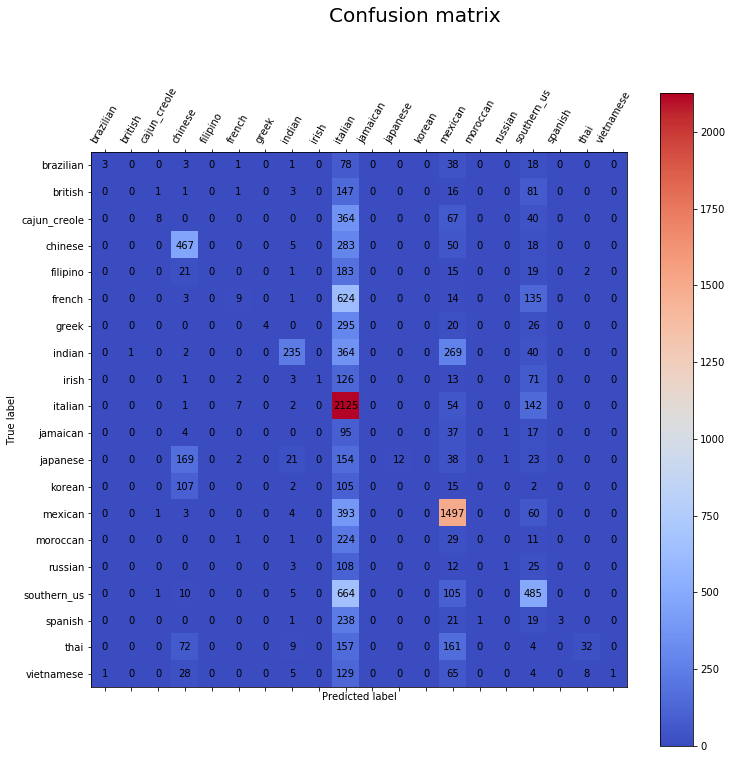

1. Accuracy = 0.40923566879 (i.e. 40.923566879 %)

2. f1_scores for each class:

           brazilian:	0.0411
             british:	0.0000
        cajun_creole:	0.0327
             chinese:	0.5446
            filipino:	0.0000
              french:	0.0222
               greek:	0.0229
              indian:	0.3875
               irish:	0.0092
             italian:	0.4626
            jamaican:	0.0000
            japanese:	0.0556
              korean:	0.0000
             mexican:	0.6662
            moroccan:	0.0000
             russian:	0.0132
         southern_us:	0.3865
             spanish:	0.0210
                thai:	0.1342
          vietnamese:	0.0083


3. avg f1_score (without considering class imbalance): 0.140379297679

4. avg f1_score (weighted by considering class imbalance): 0.319749399916



In [147]:
# analyze on our own train-test split
baseline_2_model = Baseline_2_Model()
baseline_2_model.train('my_train_split.json')
baseline_2_model.validate('my_test_split.json')

Note: Above code took around 30 minutes to calculate predictions

** Inferences from above results **

1. From the confusion matrix, we can see that this model predicts some cuisines a lot of times (such as italian, mexican). This is probably because of the fact that since these cuisines occur a lot frequently, their score tends to become significant because of many (though small) score contributions. We can try a different heuristic by adding a larger power of common ingredients to handle this issue (see Baseline 2b)
2. Accuracy that we achieve here is about 40%
3. From the f1-scores of each class, it is immediately apparent that those cuisines that we predict frequently (such as italian, mexican, southern_us, etc.) have higher f1-scores than those cuisines that we predict sparingly (such as brazilian, irish, moroccan, etc.). This is not surprising given the logic with which the model is making the predictions
4. Due to this imbalance of f1-scores based on the frequency of cuisine's occurrence, the unweighted average f1-score turns out to be significanly smaller (around 0.14) than its weighted counterpart (around 0.31)

Now we train the baseline model on entire training data that is available and then make predictions on Kaggle's test data (whose ground truth we don't know) and submit on Kaggle to check the accuracy we get

In [148]:
# train on entire data set and check accuracy on Kaggle
baseline_2_model_whole = Baseline_2_Model()
baseline_2_model_whole.train('whats-cooking/train.json')
baseline_2_model_whole.write_prediction('whats-cooking/test.json', 'Submissions/baseline_2_submission.csv')

0.0% of predictions done
9.99597747385% of predictions done
19.9919549477% of predictions done
29.9879324216% of predictions done
39.9839098954% of predictions done
49.9798873693% of predictions done
59.9758648431% of predictions done
69.971842317% of predictions done
79.9678197908% of predictions done
89.9637972647% of predictions done
99.9597747385% of predictions done


I submitted the results of above baseline on Kaggle and got an accuracy of 0.40335 (i.e. **40.335 %**). The accuracy is similar to the one we got on our own train-test split.

#### Baseline #2(b)
This is same as Baseline #2 except here we add a higher power of number of common ingredients (in particular, power 3 i.e. cube) instead of power 1. This is in hope that this may help tackle the issue faced by previous model

In [158]:
import json
import operator

class Baseline_2b_Model:
    
    def __init__(self):
        is_trained = False
    
    # trains the model with entries from train_file
    def train(self, train_file):
        self.recipes = []
        with open(train_file, 'r') as file:
            data = json.load(file)    
            for recipe in data:
                self.recipes.append(recipe)
        self.is_trained = True
    
    # returns prediction results for entries of infile
    # it returns two arrays ids, predictions
    # predictions[i] is the predicted cuisine of entry with id ids[i]
    def predict(self, infile):
        assert self.is_trained, 'model not trained yet!'
        
        predictions = []
        ids = []
        with open(infile, 'r') as file:
            data = json.load(file)
            M = len(data)
            for recipe_num, recipe in enumerate(data):
                # print progress
                if recipe_num % int((M * 0.10)) == 0:
                    print('{}% of predictions done'.format(recipe_num * 100.0 / M))
                
                common_ingredient_counts = []
                for train_recipe in self.recipes:
                    common_ingredients = set(recipe['ingredients']) - (set(recipe['ingredients']) - set(train_recipe['ingredients']))
                    common_ingredient_counts.append(len(common_ingredients))

                
                # calculate score for each cuisine
                total_count = sum(common_ingredient_counts)
                W = 100000.0
                score_cuisines = {}
                for i, train_recipe in enumerate(self.recipes):
                    if train_recipe['cuisine'] not in score_cuisines:
                            score_cuisines[train_recipe['cuisine']] = 0.0
                    score_cuisines[train_recipe['cuisine']] += (float(pow(common_ingredient_counts[i], 3)) / total_count)
                    
                # pick the cuisine with highest score
                predicted_cuisine = max(score_cuisines.iteritems(), key=operator.itemgetter(1))[0]
                predictions.append(predicted_cuisine)
                ids.append(recipe['id'])
                
        return ids, predictions
    
    # validates already trained model against entries from validation_file
    def validate(self, validation_file):
        assert self.is_trained, 'model not trained yet!'
        ids, predictions = self.predict(validation_file)
        id_to_ground_truth_cuisine = {}
        with open(validation_file, 'r') as infile:
            data = json.load(infile)
            for recipe in data:
                id_to_ground_truth_cuisine[recipe['id']] = recipe['cuisine']
        ground_truth_labels = [id_to_ground_truth_cuisine[id] for id in ids]
        common_validate(ground_truth_labels, predictions)
    
    # writes out prediction of already trained model on entries of test_file to out_file
    # out_file can then be submitted on Kaggle
    def write_prediction(self, test_file, outfile):
        assert self.is_trained, 'model not trained yet!'
        with open(outfile, 'w') as out_file:
            out_file.write('id,cuisine\n')
            ids, predictions = self.predict(test_file)
            assert len(ids) == len(predictions), 'these should be equal'
            N = len(ids)
            for i in range(N):
                out_file.write('{},{}\n'.format(ids[i], predictions[i]))

0.0% of predictions done
9.99832383507% of predictions done
19.9966476701% of predictions done
29.9949715052% of predictions done
39.9932953403% of predictions done
49.9916191753% of predictions done
59.9899430104% of predictions done
69.9882668455% of predictions done
79.9865906805% of predictions done
89.9849145156% of predictions done
99.9832383507% of predictions done


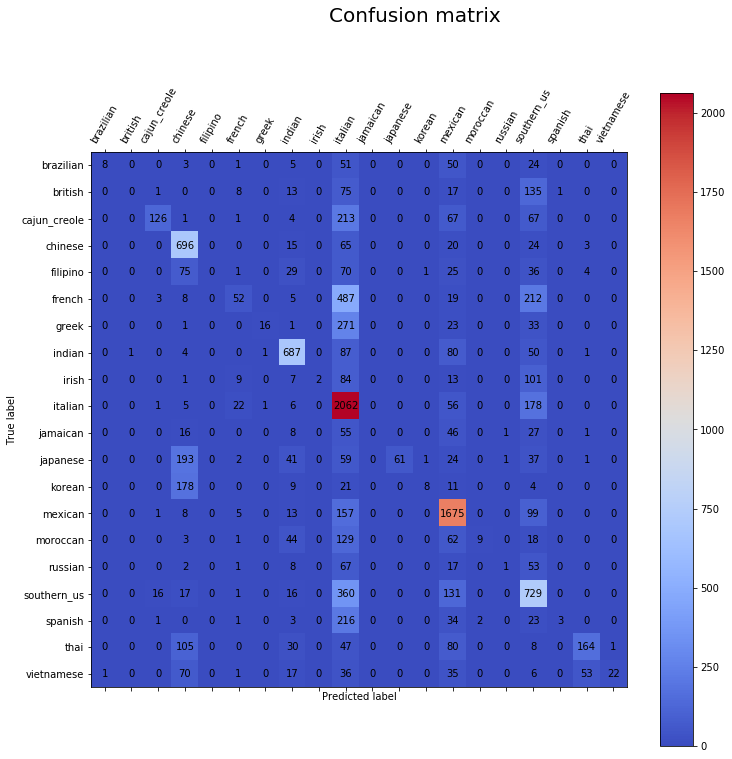

1. Accuracy = 0.52975192759 (i.e. 52.975192759 %)

2. f1_scores for each class:

           brazilian:	0.1060
             british:	0.0000
        cajun_creole:	0.4013
             chinese:	0.6301
            filipino:	0.0000
              french:	0.1166
               greek:	0.0882
              indian:	0.7340
               irish:	0.0183
             italian:	0.5940
            jamaican:	0.0000
            japanese:	0.2536
              korean:	0.0664
             mexican:	0.7540
            moroccan:	0.0650
             russian:	0.0132
         southern_us:	0.4652
             spanish:	0.0209
                thai:	0.4955
          vietnamese:	0.1667


3. avg f1_score (without considering class imbalance): 0.249438635292

4. avg f1_score (weighted by considering class imbalance): 0.450467479212



In [159]:
# analyze on our own train-test split
baseline_2b_model = Baseline_2b_Model()
baseline_2b_model.train('my_train_split.json')
baseline_2b_model.validate('my_test_split.json')

Note: Above code took around 30 minutes to calculate predictions

** Inferences from above results are identical to those of Baseline #1 **

Now we train this baseline model on entire training data that is available and then make predictions on Kaggle's test data (whose ground truth we don't know) and submit on Kaggle to check the accuracy we get

In [160]:
# train on entire data set and check accuracy on Kaggle
baseline_2b_model_whole = Baseline_2b_Model()
baseline_2b_model_whole.train('whats-cooking/train.json')
baseline_2b_model_whole.write_prediction('whats-cooking/test.json', 'Submissions/baseline_2b_submission.csv')

0.0% of predictions done
9.99597747385% of predictions done
19.9919549477% of predictions done
29.9879324216% of predictions done
39.9839098954% of predictions done
49.9798873693% of predictions done
59.9758648431% of predictions done
69.971842317% of predictions done
79.9678197908% of predictions done
89.9637972647% of predictions done
99.9597747385% of predictions done


I submitted the results of above baseline on Kaggle and got an accuracy of 0.52916 (i.e. **52.916 %**). The accuracy is similar to the one we got on our own train-test split.

### 5. Machine Learning

Create train/test X, y matrices (1-hot encoding)

Train a neural network on these 1-hot encoded matrices